In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy.stats import zscore
from sklearn.cluster import KMeans

In [2]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',200)

In [3]:
df=pd.read_csv('Data/Online_Retail_Data_Set.csv',encoding = 'ISO-8859-1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
df.shape

(541909, 8)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Droping the rows that have missing values in CustomerID column because this rows seems not to be useful for segmenting customer as imputation of CustomerID won't work efficiently.

In [7]:
df=df.drop(df[df['CustomerID'].isna()==True].index,axis=0)

In [8]:
df.shape

(406829, 8)

In [9]:
df.isna().sum()  #rechecking missing values

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

# Data Analysis

In [10]:
df['Country'].value_counts()
# Maximum orders are coming from UK

United Kingdom          361878
Germany                   9495
France                    8491
EIRE                      7485
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               1877
Portugal                  1480
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
USA                        291
Israel                     250
Unspecified                244
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon                     45
Lithuani

In [11]:
print(df['Country'].unique())
print('Total no. of countries from where customers belong: ',df['Country'].nunique())

['United Kingdom' 'France' 'Australia' 'Netherlands' 'Germany' 'Norway'
 'EIRE' 'Switzerland' 'Spain' 'Poland' 'Portugal' 'Italy' 'Belgium'
 'Lithuania' 'Japan' 'Iceland' 'Channel Islands' 'Denmark' 'Cyprus'
 'Sweden' 'Austria' 'Israel' 'Finland' 'Greece' 'Singapore' 'Lebanon'
 'United Arab Emirates' 'Saudi Arabia' 'Czech Republic' 'Canada'
 'Unspecified' 'Brazil' 'USA' 'European Community' 'Bahrain' 'Malta' 'RSA']
Total no. of countries from where customers belong:  37


In [12]:
print('Total no. of customers: ',df['CustomerID'].nunique())
print('Total transactions done: ',df['InvoiceNo'].nunique())
print('Products sold are : ',df['StockCode'].nunique())

Total no. of customers:  4372
Total transactions done:  22190
Products sold are :  3684


In [13]:
# Need to check the cancelled orders as well as they are of not use for customer segmentation,
#'C'mentioned before the Invoiceno indicates that the order is cancelled
df[df['InvoiceNo'].apply(lambda x: x[0]=='C')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12/9/2011 9:57,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,12/9/2011 10:28,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12/9/2011 11:57,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,12/9/2011 11:58,1.25,17315.0,United Kingdom


In [14]:
percent_transaction_cancelled = round((df[df['InvoiceNo'].apply(lambda x: x[0]=='C')]['InvoiceNo'].nunique()/ df['InvoiceNo'].nunique())*100,2)
print('Percentage of Transactions cancelled are : ',percent_transaction_cancelled)

Percentage of Transactions cancelled are :  16.47


Droping rows that contains cancelled order as it won't be helpful for customer segmentation.

In [15]:
df=df.drop(df[df['InvoiceNo'].apply(lambda x: x[0]=='C')].index,axis=0)
df.shape

(397924, 8)

Creating new columns like Amount (total amount of purchase per customerID), Frequency (no. of times customer visiting the webpage) and Recency(how many days before customer did a transaction from today).

In [16]:
df['Amount'] = df['Quantity'] * df['UnitPrice']

In [17]:
a=df.groupby('CustomerID').sum()['Amount']
a= a.reset_index()

In [18]:
a.head()

,CustomerID,Amount
0,12346.0,77183.60
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [19]:
b= df.groupby('CustomerID')['InvoiceNo'].count()
b= b.reset_index()
b.columns = ['CustomerID', 'Frequency']

In [20]:
b.head()

,CustomerID,Frequency
0,12346.0,1
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [21]:
df1= pd.merge(a, b, on='CustomerID', how='inner')
df1.head()

,CustomerID,Amount,Frequency
0,12346.0,77183.60,1
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [22]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
max_date = df['InvoiceDate'].max()
max_date

Timestamp('2011-12-09 12:50:00')

In [23]:
df['days_diff'] = max_date - df['InvoiceDate']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,days_diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [24]:
c = df.groupby('CustomerID')['days_diff'].min()
c = c.reset_index()
c.head()

,CustomerID,days_diff
0,12346.0,325 days 02:49:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [25]:
c['days_diff'] = c['days_diff'].dt.days
c.head()

,CustomerID,days_diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [26]:
df1 = pd.merge(df1, c, on='CustomerID', how='inner')
df1.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
df1.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,77183.60,1,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


In [27]:
df2=df1[['Amount','Frequency','Recency']]   # using only Amount, Frequency and Recency to find the customer segments.

In [28]:
df1_scaled = df2.apply(zscore)    # scaling of data is required as all the calculations is based on distance
df1_scaled.head()

,Amount,Frequency,Recency
0,8.359634,-0.396512,2.334858
1,0.251046,0.394688,-0.905199
2,-0.028546,-0.265374,-0.175186
3,-0.032963,-0.081781,-0.735196
4,-0.191315,-0.326572,2.174855


# K-Means Clustering

In [29]:
kmeans = KMeans(random_state=2)
kmeans.fit(df1_scaled)

KMeans(random_state=2)

In [30]:
cluster_range = range( 1, 15 )
cluster_errors = []
for num_clusters in cluster_range:
    clusters = KMeans( num_clusters, n_init = 10 )
    clusters.fit(df1_scaled)
    cluster_errors.append( clusters.inertia_ )
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )
clusters_df[0:15]

,num_clusters,cluster_errors
0,1,13017.000000
1,2,8996.812576
2,3,5452.648368
3,4,4000.237368
4,5,2958.101343
5,6,2371.064590
6,7,1923.317474
7,8,1674.443015
8,9,1495.521674
9,10,1311.321194


In [ ]:
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

From the cluster table above, the drop of error is low from cluster no. 3 which is also evident from elbow plot, thus we can expect our customers are divided into 3 segments.

In [32]:
kmeans = KMeans(n_clusters=3, n_init = 15, random_state=2)
kmeans.fit(df1_scaled)
centroids = kmeans.cluster_centers_
centroid_df = pd.DataFrame(centroids, columns = list(df1_scaled) )
centroid_df

,Amount,Frequency,Recency
0,-0.002798,0.049747,-0.511812
1,-0.157614,-0.279402,1.546944
2,13.804560,10.815795,-0.878276


In [33]:
df_labels = pd.DataFrame(kmeans.labels_ , columns = list(['labels']))
df_labels['labels'] = df_labels['labels'].astype('category')

In [34]:
df_kmeans = df1.join(df_labels)
df_kmeans.head()

,CustomerID,Amount,Frequency,Recency,labels
0,12346.0,77183.60,1,325,1
1,12347.0,4310.00,182,1,0
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,0
4,12350.0,334.40,17,309,1


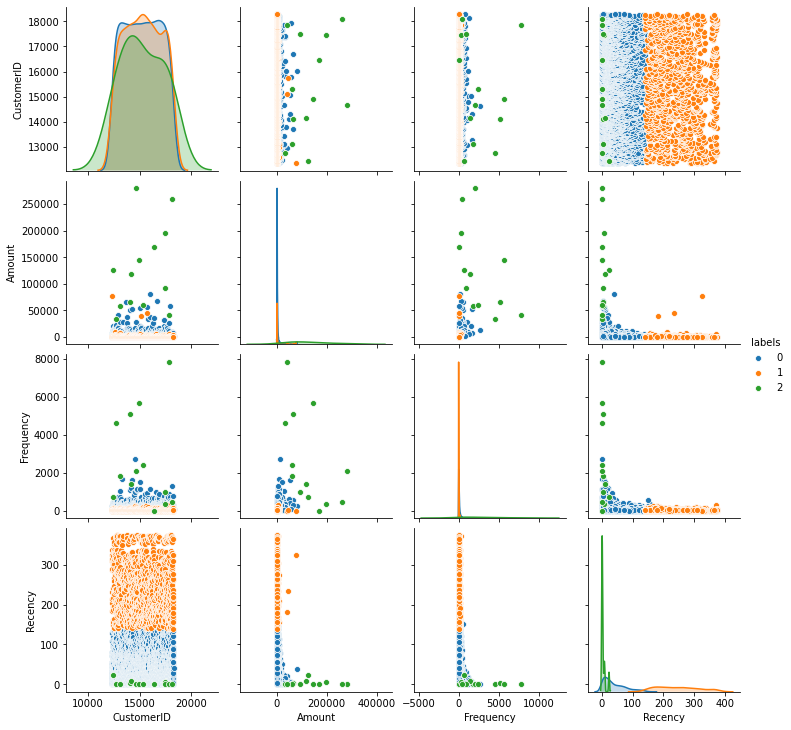

In [35]:
sns.pairplot(df_kmeans,diag_kind='kde',hue='labels')

# Hierarchical Clustering

In [36]:
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering
Z = linkage(df1_scaled, method='ward',metric='euclidean')
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

Dendrogram Truncation

In [ ]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

In [ ]:
hie_clus = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
labels = hie_clus.fit_predict(df1_scaled)

df_h = df1.copy(deep=True)
df_h['label'] = labels
df_h['label']=df_h['label'].astype('category')
df_h.head()

In [ ]:
sns.pairplot(df_h,diag_kind='kde',hue='label')

# Inferences

From the centroids of Kmeans clustering:
1. Customers belonging to cluster 0 are the ones who recently visited but have moderate frequency to visit the webpage and purchase products  of moderate amount.
2. Customers belonging to cluster 1 are the ones who haven't visited the webpage recently, frequency is the lowest with least transaction amount.
3. Customers belonging to cluster 2 are the ones seems to be loyal customers as they are frequently visiting the webpage with the huge transaction amount.

From Hierarchical clustering:
1. Customers belonging to cluster 0 are loyal customers which are same as Kmeans cluster 2.
2. Customers belonging to cluster 1 are the potential customers sam as Kmeans cluster 0.
3. Customers belonging to cluster 2 are same as Kmeans cluster 1. 

Thus focus must be more on retaining the customers belonging to cluster 2 (kmeans) and cluster 0 (hierarchical) providing better services and discounts. Also customers belonging to cluster 0 (kmeans) and cluster 1 (hierarchical) are the potential customers who can convert into loyal cutsomers.For the same, a survey form could be send to those customers to understand their needs and preferences that can be work upon.